# Running SCORE on a Single Image

## Import Libraries

In [48]:
%matplotlib inline
import sys
import pickle

# Define paths and directories
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
data_path = '/gpfswork/rech/xdy/uze68md/data/'

# Add library path to PYTHONPATH
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

# Load libraries
from score import score
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [49]:
f = open(data_path+"cfht_batch.pkl", "rb")
batch = pickle.load(f)
f.close()

In [50]:
for key in batch:
    print(key, batch[key].shape)
    
n_batch = batch['psf_hst'].shape[0]
# generate the psfs in the spatial domain
shape = batch['inputs'].shape[1:]
psf_hst = np.fft.ifftshift(np.fft.irfft2(batch['psf_hst'][0], s=shape))
psf_tile_cfht = np.array([np.fft.ifftshift(np.fft.irfft2(p, s=shape)) for p in batch['psf_cfht']])
# make psf tiles
psf_tile_hst = np.repeat(psf_hst[np.newaxis, :, :], n_batch, axis=0)

flux_radius (3072,)
inputs (3072, 64, 64)
mag_auto (3072,)
ps_cfht (3072, 64, 33)
ps_hst (3072, 64, 33)
psf_cfht (3072, 128, 65)
psf_hst (3072, 128, 65)
targets (3072, 64, 64)
attributes (3072, 2)
inputs_noiseless (3072, 64, 64, 1)
inputs_cfht (3072, 128, 128)
inputs_tikho (3072, 64, 64)
windows (3072, 64, 64)
windows_flag (3072,)
targets_mom (2, 3072)
target_ell (2, 3072)


In [51]:
gals_obs = batch['inputs'][batch['windows_flag']][:2]
# psfs = np.array([np.fft.ifftshift(np.fft.irfft2(p, s=[64,64])) for p in batch['psf_cfht'][batch['windows_flag']][:2]])
psfs = psf_tile_cfht[batch['windows_flag']][:2]
# psf_hst = np.fft.ifftshift(np.fft.irfft2(batch['psf_hst'][0], s=[64,64]))

## Initialize SCORE

In [52]:
#initiate instances of score
#set the value of gamma
g1 = score(gamma=1,rip=True,verbose=False)

## Run SCORE

In [53]:
#loop
sol_g1 = []

for obs, psf in zip(gals_obs,psfs):
    #deconvolve
    g1.deconvolve(obs=obs,psf=psf)
    sol_g1 += [g1.solution]

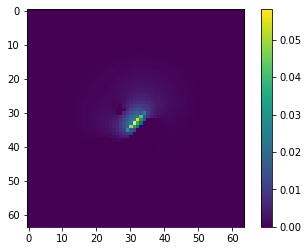

In [54]:
plt.imshow(sol_g1[0]);plt.colorbar()

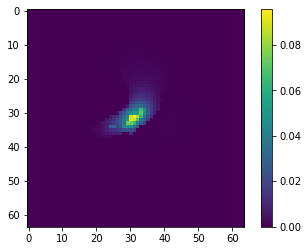

In [55]:
plt.imshow(sol_g1[1]);plt.colorbar()

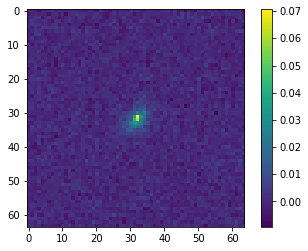

In [56]:
plt.imshow(batch['targets'][batch['windows_flag']][0]);plt.colorbar()

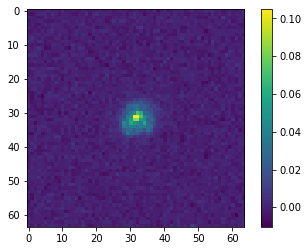

In [57]:
plt.imshow(batch['targets'][batch['windows_flag']][1]);plt.colorbar()

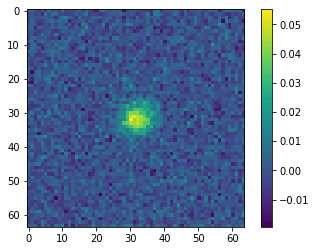

In [63]:
from scipy.signal import convolve
plt.imshow(batch['inputs'][batch['windows_flag']][1]);plt.colorbar()

## Save Solution

In [68]:
filename = data_path + 'score_g1'
np.save(filename,np.array(sol_g1))